# Анализ лояльности пользователей Яндекс Афиши

- Автор: Литвинов Олег Игоревич
- Дата: 09/12/2025

### Цели и задачи проекта

Провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.

### Этапы выполнения проекта

#### Подготовка к работе
1. Создание локального репозитория (venv, .gitignore)
2. Создание репозитория на Github
3. Создание .env с конфигурацией данных для подключения к бд
#### Загрузка данных и знакомство с ними
1. Подключение к бд через .env
2. SQL запрос для выгрузки в датафрейм
3. Общая информация о данных
#### Предобработка данных
1. Обработка данных по выручке
2. Проверка пропусков
3. Проверка на дубли
4. Преобразование к необходимому типу
5. Проверка данных в числовых столбцах
6. Промежуточный вывод
#### Создание профиля пользователя
1. Агрегированные признаки, описывающие поведение и профиль каждого пользователя
2. Анализ данных в разрезе каждого пользователя
#### Исследовательский анализ данных
1. Исследование признаков первого заказа
2. Исследование вернувшихся пользователей
3. Проверка продуктовых гипотез
4. Исследование поведения пользователей через показатели выручки и состава заказа
5. Исследование временных характеристик первого заказа и их влияния на повторные покупки
6. Корреляционный анализ количества покупок и признаков пользователя
#### Общие выводы и рекомендации
#### Финализация проекта и публикация в Git
1. Создание requirements.txt
2. Финальный коммит и пуш в Github 

## Подготовка к работе

Все шаги выполнены локально. Вирт окружение создано, локальный репозиторий создан.

## Загрузка данных и знакомство с ними

In [1]:
# загружаем необходимые библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import phik
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [2]:
# загружаем переменные из .env

load_dotenv()

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'), 
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

In [3]:
# создаём строку для соединения с базой данных из переменных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
# подключаемся

engine = create_engine(connection_string)

In [5]:
# пишем запрос в переменную

query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT  p.user_id,
        p.device_type_canonical,
        p.order_id,
        p.created_dt_msk AS order_dt,
        p.created_ts_msk AS order_ts,
        p.currency_code,
        p.revenue,
        p.tickets_count,
        EXTRACT(DAY FROM (created_dt_msk - LAG(created_dt_msk) OVER(
            PARTITION BY user_id 
            ORDER BY created_dt_msk
          ))) AS days_since_prev,
        p.event_id,
        e.event_name_code AS event_name,
        e.event_type_main,
        p.service_name,
        r.region_name,
        c.city_name
FROM afisha.purchases AS p
JOIN afisha.events e USING(event_id)
LEFT JOIN afisha.city c USING(city_id)
LEFT JOIN afisha.regions r USING(region_id)
WHERE p.device_type_canonical IN ('mobile', 'desktop') and e.event_type_main != 'фильм'
ORDER BY p.user_id
;
'''

In [6]:
# получаем результат, записываем в датафрейм

df = pd.read_sql_query(query, con=engine) 
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [7]:
# общая информация о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Датасет содержит 15 столбцов и 290611 строк, в которых представлена информация о пользователях и их заказах на сервисе `Я.Афиша`.

Описание данных:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные created_dt_msk );
- `order_ts` — дата и время создания заказа (используйте данные created_ts_msk );
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `event_name` - название мероприятия в закодированном виде;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

Наблюдения:
- имена столбцов имеют единый вид - snake case и не содержат пробелов
- данные в столбцах соответствуют описанию
- имеем хороший набор данных без пропусков (пропуски только в столбце `days_since_prev`, но мы сами их туда поставили и знаем о чём они говорят)
- по возможности можно уменьшить размер занимаемой памяти, подобрав подходящий тип данных
- большинство данных имеет тип `object` - 8 столбцов, 2 столбца с данными `datetime64`, целочисленный тип `int64` - 3 столбца, `float64` - 2

In [8]:
# сделаем копию датасета

df_original = df.copy()

# проверим

len(df_original)

290611

## Предобработка данных

### Обработка данных по выручке

In [9]:
# посмотрим в какой валюте представленны данные о выручке

df['currency_code'].value_counts()

currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

Основная часть данных - рубли, присутствуют тенге. Приведём выручку к рублю.

In [10]:
# загружаем датасет с курсом тенге к рублю

tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Имеем разный курс на разную дату, значит нужно считать выручку по каждой дате по своему курсу на эту дату. Плюс курс указан для 100 тенге.

In [11]:
# посмотрим типы данных

tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Дата - object. Для корректного объединения преобразуем в тот же тип, что и в основной таблице - datetime64[ns]

In [12]:
# преобразуем дату для присоединения

tenge_df['data'] = pd.to_datetime(tenge_df['data'])

print(f"Тип даты после преобразования: {tenge_df['data'].dtype}")
print()

# считаем курс для одного тенге в новую колонку

tenge_df['curs_for_one'] = tenge_df['curs'] / 100

tenge_df.head()

Тип даты после преобразования: datetime64[ns]



,data,nominal,curs,cdx,curs_for_one
0,2024-01-10,100,19.9391,kzt,0.199391
1,2024-01-11,100,19.7255,kzt,0.197255
2,2024-01-12,100,19.5839,kzt,0.195839
3,2024-01-13,100,19.4501,kzt,0.194501
4,2024-01-14,100,19.4501,kzt,0.194501


In [13]:
# переименовываем столбец 'data' в 'order_dt' для объединения

tenge_df = tenge_df.rename(columns={'data': 'order_dt'})

Объединяем две таблицы по столбцу order_dt, так мы получим для каждого заказа актуальный курс одного тенге на дату заказа

In [14]:
# присоединяем

df = df.merge(tenge_df[['order_dt', 'curs_for_one']], on='order_dt',how='left')

# проверяем

df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,curs_for_one
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,0.186972
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,0.183419
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,0.196475
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,0.185010
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,0.196648


In [15]:
# проверим на пропуски - везде ли совпали даты

df['curs_for_one'].isna().any()

np.False_

In [16]:
# напишем функцию, которая для каждой строки в которой currency_code - kzt, посчитает выручку по актуальному на эту дату курсу
# если строка не kzt - вернёт выручку в рублях

def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return round(row['revenue'] * row['curs_for_one'], 2)
    else:
        return row['revenue']

# запишем в новый столбец

df['revenue_rub'] = df.apply(convert_to_rub, axis=1)

In [17]:
# проверим - выведем несколько строк

df[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,curs_for_one,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,0.190125,98.50
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,0.189330,65.73
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,0.185991,61.15
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,0.198928,4380.70
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,0.199833,1478.30


### Проверка пропусков

In [18]:
# посчитаем пропуски во всей таблице

missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)

print(f"Пропуски:")
print(f"\n{missing}")
print(f"\nПроцент проопусков:")
print(f"\n{missing_pct}") 

Пропуски:

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
curs_for_one                 0
revenue_rub                  0
dtype: int64

Процент проопусков:

user_id                  0.00
device_type_canonical    0.00
order_id                 0.00
order_dt                 0.00
order_ts                 0.00
currency_code            0.00
revenue                  0.00
tickets_count            0.00
days_since_prev          7.55
event_id                 0.00
event_name               0.00
event_type_main          0.00
service_name             0.00
region_name              0.00
city_na

Пропуски в столбце `days_since_prev` ожидаемы и объяснимы - мы сами их туда добавили и знаем, что это первая покупка пользователя и для некоторых пользователей - единственная.

Других пропусков нет.

### Проверка дублей

In [19]:
# проверка полных дубликатов

full_duplicates = df.duplicated().sum()

full_duplicates

np.int64(0)

In [20]:
# проверка дубликатов по order_id

orderid_duplicates = df['order_id'].duplicated().sum()

orderid_duplicates

np.int64(0)

In [21]:
# проверка логических дубликатов (один пользователь, одно время, одно мероприятие)

logical_duplicates = df.duplicated(subset=['user_id', 'order_ts', 'event_id', 'revenue_rub', 'tickets_count', 'event_name'], keep=False).sum()

logical_duplicates

np.int64(85)

In [22]:
# посмотрим на них

df[df.duplicated(subset=['user_id', 'order_ts', 'event_id', 'revenue_rub', 'tickets_count', 'event_name'], keep=False)].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,curs_for_one,revenue_rub
11758,06eb7897f65b433,mobile,1123983,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,Билеты в руки,Светополянский округ,Глиноград,0.188553,69.82
11759,06eb7897f65b433,mobile,1123867,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,Билеты в руки,Светополянский округ,Глиноград,0.188553,69.82
12677,08199117318954f,desktop,5592970,2024-07-31,2024-07-31 11:52:06,rub,0.00,3,0.0,553623,8aa79719-8122-4b50-ae2a-fa484d034c5c,другое,Билеты без проблем,Каменевский регион,Глиногорск,0.182404,0.00
12678,08199117318954f,mobile,5593202,2024-07-31,2024-07-31 11:52:06,rub,0.00,3,0.0,553623,8aa79719-8122-4b50-ae2a-fa484d034c5c,другое,Билеты без проблем,Каменевский регион,Глиногорск,0.182404,0.00
26868,0dc525d7bacbb0d,desktop,1930763,2024-07-31,2024-07-31 13:26:11,rub,1556.05,3,11.0,393430,b33d7a0b-a715-47e3-803e-02482884a73e,концерты,Лови билет!,Каменевский регион,Глиногорск,0.182404,1556.05


Видим неполные дубликаты. Разница только в order_id и device_type_canonical. Моя логика заключается в следующем:
- одно устройство / одно время / разные order_id - нормальная ситуация. пользователь добавил несколько заказов на одно мероприятие в корзину и оплатил сразу. В итоге два разных заказа / один пользователь / одно время оплаты / одно устройство. Тут главное, что добавил не количество билетов в заказ, а добавил в корзину заказ на такое же количесво билетов и то же мероприятие. Отсюда разные order_id, но всё остальное совпадает.
- разные устройства - это уже похоже на ошибку. не может пользователь в одну секунду сделать заказы с разных устройств.

Проверим сколько одинаковых заказов оформлены с разных устройств в одну секунду одним пользователем на одно событие

In [23]:
# по каким ключам группируем

key = ['user_id', 'order_ts', 'event_id', 'revenue_rub', 'tickets_count', 'event_name']

# считаем уникальные девайсы в группах

dups = df.groupby(key)['device_type_canonical'].nunique()

# все комбинации ключей, где были несколько разных устройств

bad_dups = dups[dups > 1].index 

print(f"\nгрупп с разными устройствами: {len(bad_dups)}")

# берём строки по этим ключам

dups_orders = df.set_index(key).loc[bad_dups]

# сбрасываем индекс, чтобы снова были обычные колонки

dups_orders = dups_orders.reset_index()

# показываем нужные поля

dups_orders[['order_id', 'device_type_canonical'] + key]


групп с разными устройствами: 4


,order_id,device_type_canonical,user_id,order_ts,event_id,revenue_rub,tickets_count,event_name
0,5592970,desktop,08199117318954f,2024-07-31 11:52:06,553623,0.00,3,8aa79719-8122-4b50-ae2a-fa484d034c5c
1,5593202,mobile,08199117318954f,2024-07-31 11:52:06,553623,0.00,3,8aa79719-8122-4b50-ae2a-fa484d034c5c
2,2968673,mobile,1f49b8de206b285,2024-10-01 11:32:40,574431,155.99,4,d4344522-b7cf-4539-96c8-efece75e9b16
3,5378312,desktop,1f49b8de206b285,2024-10-01 11:32:40,574431,155.99,4,d4344522-b7cf-4539-96c8-efece75e9b16
4,6249385,mobile,96368e5714d1673,2024-10-31 21:30:39,589624,125.49,3,c9eb1fa4-257b-4290-975a-7fe34b46d11b
5,3497807,desktop,96368e5714d1673,2024-10-31 21:30:39,589624,125.49,3,c9eb1fa4-257b-4290-975a-7fe34b46d11b
6,964657,mobile,cdbc02c6ad8087a,2024-10-01 11:33:16,574431,77.99,2,d4344522-b7cf-4539-96c8-efece75e9b16
7,5877431,desktop,cdbc02c6ad8087a,2024-10-01 11:33:16,574431,77.99,2,d4344522-b7cf-4539-96c8-efece75e9b16


Видим несколько абсолютно одинаковых заказов одного пользователя, в одну секунду, но с разных устройств. Так как бОльшая часть заказов с мобильных, то логично оставить только мобильные заказы.

In [24]:
# тк не так много записей - удалим desktop по order_id

desktop_to_remove = dups_orders[dups_orders['device_type_canonical'] == 'desktop']

# посмотрим, что будем удалять

desktop_to_remove[['order_id', 'device_type_canonical'] + key]

,order_id,device_type_canonical,user_id,order_ts,event_id,revenue_rub,tickets_count,event_name
0,5592970,desktop,08199117318954f,2024-07-31 11:52:06,553623,0.00,3,8aa79719-8122-4b50-ae2a-fa484d034c5c
3,5378312,desktop,1f49b8de206b285,2024-10-01 11:32:40,574431,155.99,4,d4344522-b7cf-4539-96c8-efece75e9b16
5,3497807,desktop,96368e5714d1673,2024-10-31 21:30:39,589624,125.49,3,c9eb1fa4-257b-4290-975a-7fe34b46d11b
7,5877431,desktop,cdbc02c6ad8087a,2024-10-01 11:33:16,574431,77.99,2,d4344522-b7cf-4539-96c8-efece75e9b16


In [25]:
# составим список order_id, которые удаляем

orders_to_remove = desktop_to_remove['order_id'].tolist()

# посчитаем сколько строк удалим

orders_to_remove_per = round((len(orders_to_remove) / len(df) * 100),4)

print(f"Удаляем эти order_id (только десктоп дубли): {orders_to_remove}")

# удаляем

df = df[~df['order_id'].isin(orders_to_remove)].reset_index(drop=True)


print(f"Удалено строк: {len(orders_to_remove)}. Это {orders_to_remove_per}% от всех данных")
print(f"Осталось строк в датафрейме: {len(df)}")

Удаляем эти order_id (только десктоп дубли): [5592970, 5378312, 3497807, 5877431]
Удалено строк: 4. Это 0.0014% от всех данных
Осталось строк в датафрейме: 290607


### Преобразование к необходимому типу

Посмотрим какие столбцы содержат ограниченный набор данных. После преобразуем их в категории.

In [26]:
df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [27]:
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

In [28]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [29]:
df['service_name'].unique()

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

Все категориальные столбцы содержат корректные реальные категории. Нет пустых строк или прочерков и т.д.

In [30]:
# эти данные подходят под категории - преобразуем

categorical_columns = ['device_type_canonical', 'currency_code', 'event_type_main', 'service_name']

for column in categorical_columns:
    df[column] = df[column].astype('category')

Посмотрим на числовые колонки и подберём подходящий размер ячеек

In [31]:
# числа с плавающей точкой

float_columns = ['revenue', 'days_since_prev', 'curs_for_one', 'revenue_rub']

for column in float_columns:
    df[column] = df[column].astype('float32')

In [32]:
# целые числа

int_columns = ['order_id', 'event_id']

for column in int_columns:
    df[column] = df[column].astype('int32')

In [33]:
df['tickets_count'] = df['tickets_count'].astype('int8')

In [34]:
# проверим типы данных

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290607 entries, 0 to 290606
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290607 non-null  object        
 1   device_type_canonical  290607 non-null  category      
 2   order_id               290607 non-null  int32         
 3   order_dt               290607 non-null  datetime64[ns]
 4   order_ts               290607 non-null  datetime64[ns]
 5   currency_code          290607 non-null  category      
 6   revenue                290607 non-null  float32       
 7   tickets_count          290607 non-null  int8          
 8   days_since_prev        268674 non-null  float32       
 9   event_id               290607 non-null  int32         
 10  event_name             290607 non-null  object        
 11  event_type_main        290607 non-null  category      
 12  service_name           290607 non-null  cate

### Проверка данных в числовых столбцах

Проверим данные в числовых колонках на наличие в них выбросов и нелогичных / невозможных значений

In [35]:
# статистические показатели для важных колонок

df[['revenue_rub', 'tickets_count', 'days_since_prev']].describe()

,revenue_rub,tickets_count,days_since_prev
count,290607.000000,290607.000000,268674.000000
mean,555.578491,2.754307,3.222430
std,875.459045,1.170625,11.343269
min,-90.760002,1.000000,0.000000
25%,113.970001,2.000000,0.000000
50%,351.140015,3.000000,0.000000
75%,802.049988,4.000000,1.000000
max,81174.539062,57.000000,148.000000


`revenue_rub`

`Минимальное значение –90.76` явно ошибка - отрицательная выручка невозможна.
`Максимум 81174` — экстремально высокий выброс.
Медиана — 351, 75-й перцентиль — 802, значит выручка > 10 000 — явный выброс.

`tickets_count`

Основной диапазон — от 1 до 5 билетов.
Значения вроде 57 — выбросы, но это могут быть реальные заказы: корпоративные заявки, групповые билеты и т.д.

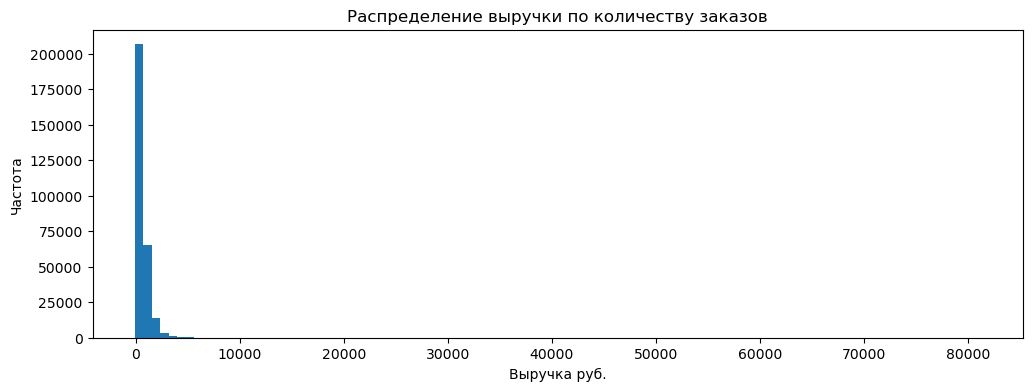

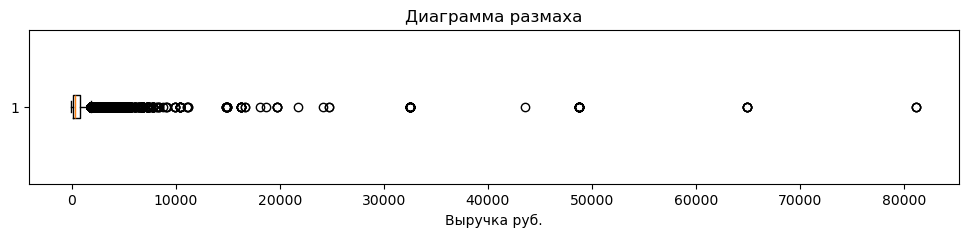

In [36]:
# построим гистограмму для revenue_rub

plt.figure(figsize=(12, 4))
plt.hist(df['revenue_rub'], bins=100)
plt.title('Распределение выручки по количеству заказов')
plt.xlabel('Выручка руб.')
plt.ylabel('Частота')
plt.show()

# боксплот для revenue_rub

plt.figure(figsize=(12, 2))
plt.boxplot(df['revenue_rub'], vert=False)
plt.title('Диаграмма размаха')
plt.xlabel('Выручка руб.')
plt.show()

графики подтверждают выбросы в revenue_rub, отфильтруем значения по 99 перцентилю

In [37]:
# посчитаем 99 перцентиль

p99 = df['revenue_rub'].quantile(0.99)
p99

np.float64(2628.419921875)

In [38]:
# фильтруем

df_filtered = df[df['revenue_rub'] <= p99]

# также убираем отрицательные значения выручки, т.к. 99 перцентиль отсекает только то, что выше

df_filtered = df_filtered[df_filtered['revenue_rub'] >= 0]

# сбрасываем индекс после фильтрации

df_filtered = df_filtered.reset_index(drop=True)

# посчитаем сколько удалили

filter_99 = len(df) - len(df_filtered)
share = round(filter_99 / len(df)*100, 2)
print(f"\nУдалено: {filter_99} строк, это {share}% от всех данных\n")


Удалено: 3206 строк, это 1.1% от всех данных



In [39]:
# посмотрим что получилось

df_filtered[['revenue_rub', 'tickets_count', 'days_since_prev']].describe()

,revenue_rub,tickets_count,days_since_prev
count,287401.000000,287401.000000,265701.000000
mean,518.725220,2.741320,3.225020
std,511.951904,1.163091,11.350303
min,0.000000,1.000000,0.000000
25%,112.610001,2.000000,0.000000
50%,344.829987,3.000000,0.000000
75%,788.900024,3.000000,1.000000
max,2628.419922,57.000000,148.000000


Минимальное значение выручки равное нулю оставим, т.к. скорее всего это заказы, оформленные в подарок / на бонусы / призовые и т.д. То есть они реальные и для них есть даты и количество билетов, которые можно проанализировать

### Промежуточный вывод

В процессе предобработки данных были сделаны следующие шаги:
- проверка на пропуски показала, что выгрузка из базы данных корректная и пропуски только там, где я их оставил сам.
- провел проверку на дубликаты и нешёл несколько строк, которые содержат одинаковые заказы, одного пользователя в одну и ту же секунду, но с разных устройств. Принял решение удалить десктоп заказы, мобильные оставить.
- выяснил, что данные по выручке хранятся в разных валютах - конвертировал тенге в российский рубль по актуальному курсу на дату совершения покупки и сохранил его в новый столбец.
- сократил размер датафрейма, приведя данные к подходящему типу. там, где возможно привел object к категориальному типу и уменьшил разрядность числовых данных.
- провел проверку в числовых столбцах, определил выбросы, подтвердил их визуально на графиках - отфильтровал по 99 процентилю и удалил отрицательные значения выручки.

## Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас построим агрегированные признаки, описывающие поведение и профиль каждого пользователя.

In [40]:
# отсортируем таблицу по времени совершения заказа и user_id

df_sorted = df_filtered.sort_values(['user_id','order_ts']).reset_index(drop=True)

df_sorted.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,curs_for_one,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,0.186972,1521.939941
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.450012,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,0.183419,289.450012
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.569946,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,0.196475,1258.569946
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.490000,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,0.185010,8.490000
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.410034,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,0.196648,1390.410034


In [41]:
# группируем в отдельную таблицу пользователей и считаем данные

user_profiles = df_sorted.groupby('user_id').agg({
    'order_dt': ['min', 'max'],  # первый и последний заказ
    'order_id': 'count',  # количество заказов
    'revenue_rub': 'mean',  # средняя выручка
    'tickets_count': 'mean',  # среднее количество билетов
    'days_since_prev': 'mean'  # среднее время между заказами
}).reset_index()

# переименуем столбцы для понимания

user_profiles.columns = ['user_id', 'first_order_date', 'last_order_date', 
                         'total_orders', 'avg_revenue', 'avg_tickets_count', 
                         'avg_days_between_orders']

user_profiles.head()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010010,3.000000,75.0
2,000898990054619,2024-07-13,2024-10-23,3,767.213379,2.666667,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.500000,16.0


In [42]:
# находим первые заказы и их данные - берём первые строки для user_id
# в отсортированной по времени заказа таблице df_sorted

first_orders = df_sorted.groupby('user_id').first()[['device_type_canonical', 'region_name', 
                                                     'service_name', 'event_type_main']].reset_index()

# переименуем столбцы для понимания

first_orders.columns = ['user_id', 'first_device', 'first_region', 'first_service', 'first_event_type']

first_orders.head()

,user_id,first_device,first_region,first_service,first_event_type
0,0002849b70a3ce2,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,mobile,Североярская область,Лови билет!,другое
3,00096d1f542ab2b,desktop,Каменевский регион,Край билетов,театр
4,000a55a418c128c,mobile,Поленовский край,Лучшие билеты,театр


In [43]:
# объединяем первые заказы с профилями по user_id

user_profiles = user_profiles.merge(first_orders, on='user_id', how='left')

user_profiles.head()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,first_device,first_region,first_service,first_event_type
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.000000,NaN,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010010,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,2024-07-13,2024-10-23,3,767.213379,2.666667,51.0,mobile,Североярская область,Лови билет!,другое
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.000000,NaN,desktop,Каменевский регион,Край билетов,театр
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр


In [44]:
# бинарные признаки для 2+ и 5+ заказов

user_profiles['is_two'] = user_profiles['total_orders'] >= 2
user_profiles['is_five'] = user_profiles['total_orders'] >= 5

user_profiles.head()

,user_id,first_order_date,last_order_date,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,first_device,first_region,first_service,first_event_type,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.000000,NaN,mobile,Каменевский регион,Край билетов,театр,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010010,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки,True,False
2,000898990054619,2024-07-13,2024-10-23,3,767.213379,2.666667,51.0,mobile,Североярская область,Лови билет!,другое,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.000000,NaN,desktop,Каменевский регион,Край билетов,театр,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр,True,False


### Анализ качества данных профилей

Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными работаем: насколько они репрезентативны и нет ли в них аномалий.

In [45]:
# посмотрим общую информацию по таблице

print(f"общее число пользователей в выборке: {len(user_profiles)}")
print(f"средняя выручка с одного заказа: {df_sorted['revenue_rub'].mean():.2f}") # берём заказы, а не пользователей
print(f"количество пользователей, совершивших 2 и более заказа: {user_profiles['is_two'].sum()}")
print(f"количество пользователей, совершивших 5 и более заказа: {user_profiles['is_five'].sum()}")
print(f"доля пользователей, совершивших 2 и более заказа: {user_profiles['is_two'].mean():.2f}")
print(f"доля пользователей, совершивших 5 и более заказа: {user_profiles['is_five'].mean():.2f}")

общее число пользователей в выборке: 21838
средняя выручка с одного заказа: 518.73
количество пользователей, совершивших 2 и более заказа: 13475
количество пользователей, совершивших 5 и более заказа: 6332
доля пользователей, совершивших 2 и более заказа: 0.62
доля пользователей, совершивших 5 и более заказа: 0.29


### Статистические показатели

In [46]:
user_profiles['total_orders'].describe()

count    21838.000000
mean        13.160592
std        121.575329
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: total_orders, dtype: float64

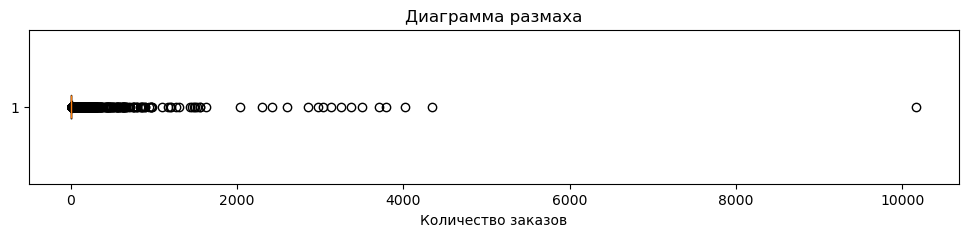

In [47]:
# обнаружен пользователь, который сделал 10168 заказов
# посмотрим боксплот

plt.figure(figsize=(12, 2))
plt.boxplot(user_profiles['total_orders'], vert=False)
plt.title('Диаграмма размаха')
plt.xlabel('Количество заказов')
plt.show()

In [48]:
# видим явные выбросы - возможно технические ошибки. посмотрим какой период анализируем

print(f"\nМы располагаем данными с {df_filtered['order_dt'].min()} до {df_filtered['order_dt'].max()}\n")


Мы располагаем данными с 2024-06-01 00:00:00 до 2024-10-31 00:00:00



Получаем количество заказов за 5 месяцев - 150 дней.
Полагаю, что выбросами и ошибкой можно считать более 2000 заказов за 150 дней.
Основная масса заказов до 1800.
До 2000 - это примерно 13 заказов в день, вполне могут делать перекупы, частные агрегаторы и т.д.

In [49]:
user_profiles['avg_tickets_count'].describe()

count    21838.000000
mean         2.744062
std          0.913083
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets_count, dtype: float64

In [50]:
# тут аномалий не обнаружено

In [51]:
user_profiles['avg_days_between_orders'].describe()

count    13504.000000
mean        15.864348
std         22.330114
min          0.000000
25%          1.000000
50%          8.000000
75%         20.500000
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [52]:
# тут аномалий не обнаружено - 148 дней между заказами, вполне укладываемся в количество дней, отведённых для анализа

In [53]:
# посмотрим значение 99.9 процентиля данных по заказам

p999 = user_profiles['total_orders'].quantile(0.999)
p999

np.float64(1462.0750000001026)

In [54]:
# близко к моей логике - по нему и отфильтруем аномалии

user_profiles_filter = user_profiles[user_profiles['total_orders'] <= p999].reset_index(drop=True)

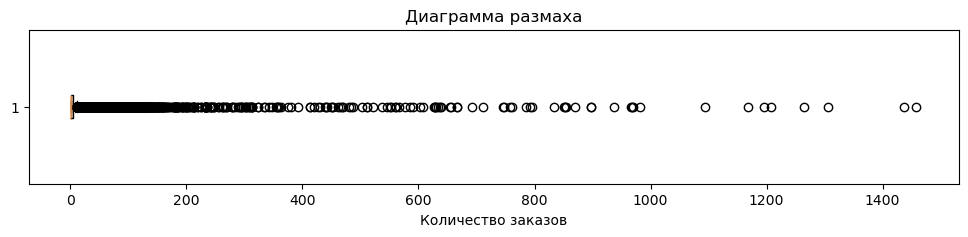

In [55]:
# посмотрим новое разпределение

plt.figure(figsize=(12, 2))
plt.boxplot(user_profiles_filter['total_orders'], vert=False)
plt.title('Диаграмма размаха')
plt.xlabel('Количество заказов')
plt.show()

In [56]:
# посчитаем потерянные данные

remove_profiles = len(user_profiles) - len(user_profiles_filter)
share_remove_profiles = round(remove_profiles / len(user_profiles)*100, 2)
print(f"\nУдалено: {remove_profiles} строк, это {share_remove_profiles}% от всех профилей\n")


Удалено: 22 строк, это 0.1% от всех профилей



### Обновлённая информация по отфильтрованным профилям пользователей

In [57]:
user_profiles_filter['total_orders'].describe()

count    21816.000000
mean        10.115145
std         48.530440
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1458.000000
Name: total_orders, dtype: float64

In [58]:
user_profiles_filter['avg_tickets_count'].describe()

count    21816.000000
mean         2.744069
std          0.913534
min          1.000000
25%          2.000000
50%          2.750000
75%          3.083333
max         11.000000
Name: avg_tickets_count, dtype: float64

In [59]:
user_profiles_filter['avg_days_between_orders'].describe()

count    13482.000000
mean        15.890137
std         22.339474
min          0.000000
25%          1.000000
50%          8.000000
75%         20.500000
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [60]:
print(f"общее число пользователей в выборке: {len(user_profiles_filter)}")
print(f"средняя выручка с одного заказа: {df_sorted['revenue_rub'].mean():.2f}")
print(f"количество пользователей, совершивших 2 и более заказа: {user_profiles_filter['is_two'].sum()}")
print(f"количество пользователей, совершивших 5 и более заказа: {user_profiles_filter['is_five'].sum()}")
print(f"доля пользователей, совершивших 2 и более заказа: {user_profiles_filter['is_two'].mean():.2f}")
print(f"доля пользователей, совершивших 5 и более заказа: {user_profiles_filter['is_five'].mean():.2f}")

общее число пользователей в выборке: 21816
средняя выручка с одного заказа: 518.73
количество пользователей, совершивших 2 и более заказа: 13453
количество пользователей, совершивших 5 и более заказа: 6310
доля пользователей, совершивших 2 и более заказа: 0.62
доля пользователей, совершивших 5 и более заказа: 0.29


## Исследовательский анализ данных
Исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используем профили пользователей.

### Исследование признаков первого заказа
Исследуем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.

In [61]:
# распределение пользователей по типу их первого мероприятия

first_event_stats = user_profiles_filter['first_event_type'].value_counts() # абсолютные значения
first_event_share = user_profiles_filter['first_event_type'].value_counts(normalize=True) # доли

display(first_event_stats)

first_event_share

first_event_type
концерты    9634
другое      5461
театр       4291
стендап     1118
спорт        800
выставки     417
ёлки          95
Name: count, dtype: int64

first_event_type
концерты    0.441602
другое      0.250321
театр       0.196691
стендап     0.051247
спорт       0.036670
выставки    0.019114
ёлки        0.004355
Name: proportion, dtype: float64

In [62]:
# распределение пользователей по типу устройства, с которого совершена первая покупка

first_device_stats = user_profiles_filter['first_device'].value_counts() # абсолютные значения
first_device_share = user_profiles_filter['first_device'].value_counts(normalize=True) # доли

display(first_device_stats)

first_device_share

first_device
mobile     18070
desktop     3746
Name: count, dtype: int64

first_device
mobile     0.828291
desktop    0.171709
Name: proportion, dtype: float64

In [63]:
# распределение пользователей по региону проведения мероприятия из первого заказа

first_region_stats = user_profiles_filter['first_region'].value_counts() # абсолютные значения
first_region_share = user_profiles_filter['first_region'].value_counts(normalize=True) # доли

display(first_region_stats.head())

first_region_share.head()

first_region
Каменевский регион      7154
Североярская область    3795
Широковская область     1234
Озернинский край         678
Малиновоярский округ     530
Name: count, dtype: int64

first_region
Каменевский регион      0.327924
Североярская область    0.173955
Широковская область     0.056564
Озернинский край        0.031078
Малиновоярский округ    0.024294
Name: proportion, dtype: float64

In [64]:
# распределение пользователей по сервису, продавшему билеты на первый заказ

first_service_stats = user_profiles_filter['first_service'].value_counts() # абсолютные значения
first_service_share = user_profiles_filter['first_service'].value_counts(normalize=True) # доли

display(first_service_stats.head())

first_service_share.head()

first_service
Билеты без проблем    5201
Мой билет             2991
Лови билет!           2847
Билеты в руки         2588
Облачко               2191
Name: count, dtype: int64

first_service
Билеты без проблем    0.238403
Мой билет             0.137101
Лови билет!           0.130501
Билеты в руки         0.118629
Облачко               0.100431
Name: proportion, dtype: float64

Распределение неравномерное. По всем четырём признакам есть выраженные точки входа:

- концерты — лидер по типу первого события: 44 %
- мобильные устройства — 83 % первых покупок делаются именно с мобильных
- каменевский регион — главный источник первых покупок: 33 %
- сервис `Билеты без проблем` — лидирует по первым покупкам: 24 %

Топ-5 сервисов:

1. Билеты без проблем
2. Мой билет
3. Лови билет!
4. Билеты в руки
5. Облачко

Почти `70 % всех первых покупок` проходят через эти 5 площадок


### Исследование вернувшихся пользователей + графики
Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа и визуализируем графики

In [65]:
# отфильтруем пользователей по заказам - нужны только 2 и более заказа

user_profiles_filter_orders = user_profiles_filter[user_profiles_filter['total_orders'] > 1]

upfo = user_profiles_filter_orders

upfo = upfo.reset_index(drop=True)

len(upfo)

13453

In [66]:
# сгруппируем по сегментами и считаем количество пользователей с 2+ заказами

upfo_first_event = upfo['first_event_type'].value_counts()
upfo_first_device = upfo['first_device'].value_counts()
upfo_first_region = upfo['first_region'].value_counts()
upfo_first_service = upfo['first_service'].value_counts()

# вычисляем долю от всех пользователей в этом сегменте
# для наглядности в %

upfo_first_event_share = ((upfo_first_event / first_event_stats)*100).round(2).sort_values(ascending=False)
upfo_first_device_share = ((upfo_first_device / first_device_stats)*100).round(2).sort_values(ascending=False)
upfo_first_region_share = ((upfo_first_region / first_region_stats)*100).round(2).sort_values(ascending=False)
upfo_first_service_share = ((upfo_first_service / first_service_stats)*100).round(2).sort_values(ascending=False)

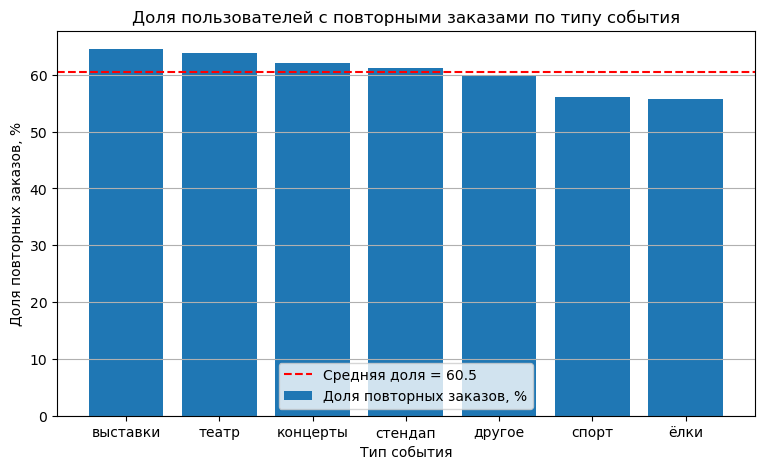

In [67]:
# средняя доля по всем мероприятиям для графика

avg_event_share = upfo_first_event_share.mean()

plt.figure(figsize=(9, 5))
bars = plt.bar(upfo_first_event_share.index, upfo_first_event_share.values, 
               label='Доля повторных заказов, %')

# добавляем среднюю

plt.axhline(avg_event_share, color='red', linestyle='--', label=f"Средняя доля = {avg_event_share:.1f}")

plt.title('Доля пользователей c повторными заказами по типу события')
plt.xlabel('Тип события')
plt.ylabel('Доля повторных заказов, %')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower center')
plt.show()

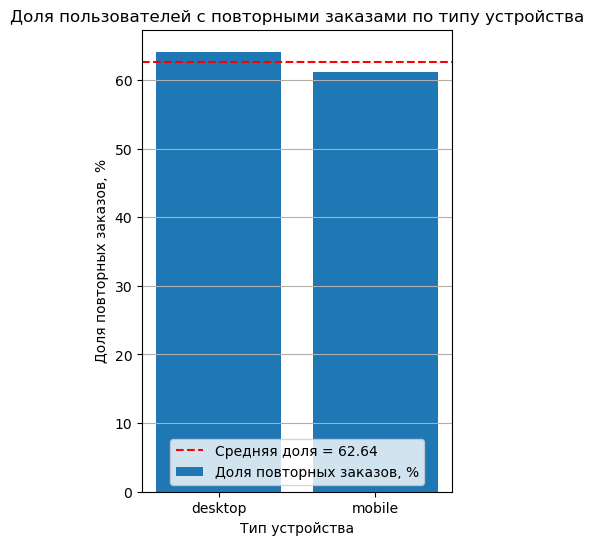

In [68]:
# средняя доля по всем устройствам

avg_device_share = upfo_first_device_share.mean()

plt.figure(figsize=(4, 6))
bars = plt.bar(upfo_first_device_share.index, upfo_first_device_share.values, 
               label='Доля повторных заказов, %')

# добавляем среднюю

plt.axhline(avg_device_share, color='red', linestyle='--', label=f"Средняя доля = {avg_device_share:.2f}")

plt.title("Доля пользователей c повторными заказами по типу устройства")
plt.xlabel('Тип устройства')
plt.ylabel('Доля повторных заказов, %')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower center')
plt.show()

In [69]:
# собираем таблицу по регионам

region_df = pd.DataFrame({
    'total': first_region_stats,
    'share': upfo_first_region_share
})

# берём топ 10 по количеству пользователей

region_top10 = region_df.sort_values('total', ascending=False).head(10)

print("\nРаспределение пользователей по сервису с долями")
display(region_top10)


Распределение пользователей по сервису с долями


,total,share
first_region,,
Каменевский регион,7154,62.75
Североярская область,3795,64.08
Широковская область,1234,64.75
Озернинский край,678,55.46
Малиновоярский округ,530,56.23
Шанырский регион,505,67.52
Травяная область,493,61.87
Светополянский округ,463,66.09
Речиновская область,445,63.82


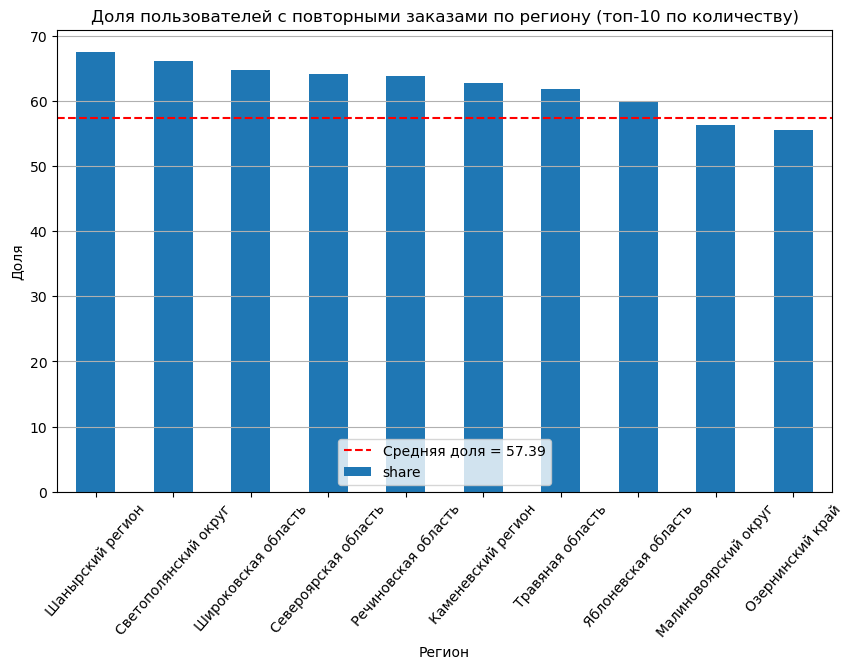

In [70]:
# сортируем топ 10 регионов по доли

region_top10_sorted_by_share = region_top10.sort_values('share', ascending=False)

# средняя доля по всем регионам

avg_region_share = region_df['share'].mean()

plt.figure(figsize=(10, 6))
region_top10_sorted_by_share['share'].plot(kind='bar')

# добавляем среднюю

plt.axhline(avg_region_share, color='red', linestyle='--', label=f"Средняя доля = {avg_region_share:.2f}")

plt.title("Доля пользователей c повторными заказами по региону (топ-10 по количеству)")
plt.xlabel('Регион')
plt.ylabel('Доля')
plt.xticks(rotation=49)
plt.grid(axis='y')
plt.legend(loc='lower center')
plt.show()

In [71]:
# собираем таблицу по сервисам

service_df = pd.DataFrame({
    'total': first_service_stats,
    'share': upfo_first_service_share
})

# берём топ 10 по количеству пользователей

service_top10 = service_df.sort_values('total', ascending=False).head(10)

print("\nРаспределение пользователей по сервису с долями")
display(service_top10)


Распределение пользователей по сервису с долями


,total,share
first_service,,
Билеты без проблем,5201,60.58
Мой билет,2991,61.15
Лови билет!,2847,61.43
Билеты в руки,2588,63.21
Облачко,2191,61.48
Весь в билетах,1304,63.42
Лучшие билеты,1186,61.47
Прачечная,588,62.93
Край билетов,459,65.58


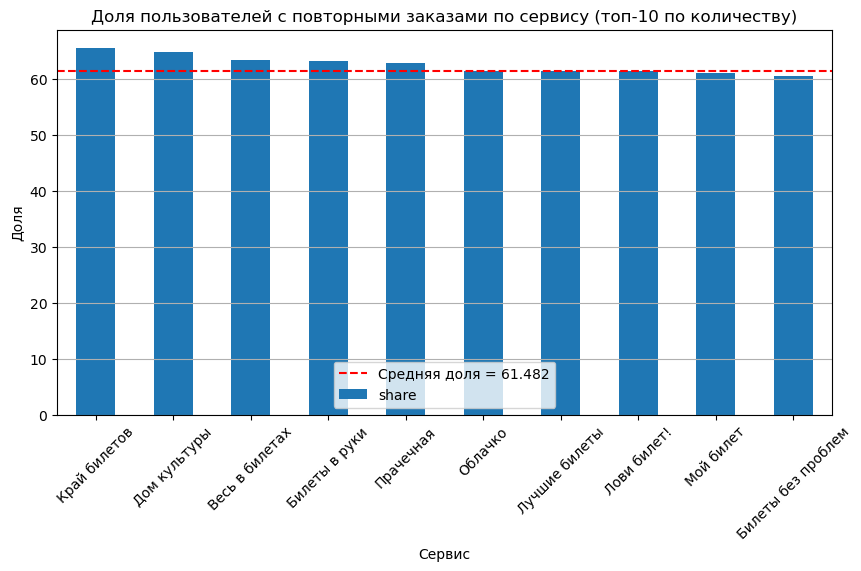

In [72]:
# сортируем топ 10 сервисов по доли

service_top10_sorted_by_share = service_top10.sort_values('share', ascending=False)

# средняя доля по всем сервисам

avg_service_share = service_df['share'].mean()

plt.figure(figsize=(10, 5))
service_top10_sorted_by_share['share'].plot(kind='bar')

# добавляем среднюю

plt.axhline(avg_service_share, color='red', linestyle='--', label=f"Средняя доля = {avg_service_share:.3f}")

plt.title("Доля пользователей c повторными заказами по сервису (топ-10 по количеству)")
plt.xlabel('Сервис')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc='lower center')
plt.show()

Чаще всего возвращаются пользователи, которые:
- впервые купили выставки, театр, концерты, стендап (в этих же сегментах доля вернувшихся выше, чем в среднем по выборке)
- использовали desktop (в этом же сегменте доля вернувшихся выше, чем в среднем по выборке, хотя показатели возвратов примерно равны, но в сегменте mobile доля вернувшихся немного ниже чем в среднем по всем устройствам)
- живут в Североярской области, Каменевском регионе, Широковской области и практически весь топ 10 регионов по количеству пользователей имеет показатель возвратов выше, чем по всем регионам в среднем (исключения - Малиновоярский округ и Озернинский край)
- впервые покупали через Край билетов, Дом культуры, Весь в билетах, Прачечную. В этих сегментах также доля вернувшихся выше чем в среднем по всем сервисам. И они также в топ 10 по количеству пользователей.

### Проверка продуктовых гипотез

Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

In [73]:
display(upfo_first_event_share.loc[['спорт', 'концерты']])

first_event_type
спорт       56.12
концерты    62.09
Name: count, dtype: float64

Как можно видеть из таблицы - гипотеза не подтверждается. Пользователи, впервые купившие билеты на спортивные мероприятия, реже возвращаются, чем те, кто пришёл через концерты.

Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.


In [74]:
# постоим корелляционную матрицу по методу Пирсона

display(region_df.corr(method='pearson'))
display(region_df.sort_values('total', ascending=False).head(10))

,total,share
total,1.000000,0.114425
share,0.114425,1.000000


,total,share
first_region,,
Каменевский регион,7154,62.75
Североярская область,3795,64.08
Широковская область,1234,64.75
Озернинский край,678,55.46
Малиновоярский округ,530,56.23
Шанырский регион,505,67.52
Травяная область,493,61.87
Светополянский округ,463,66.09
Речиновская область,445,63.82


Корреляция между размером региона и долей повторных = 0.114. Это означает:

- связь слабая.
- размер региона практически не влияет на то, насколько лояльны пользователи из него.
- крупные регионы дают много повторных пользователей только потому, что там много пользователей вообще соовершили покупки, а не потому, что там выше удержание. Это так же видно из таблицы с данными. Доля повторных покупок в `Шанырский регион` (топ-6) больше, чем в любом из топ-5 регионах по количеству пользователей.

### Исследование поведения пользователей через показатели выручки и состава заказа
Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Проследим связь между средней выручкой сервиса с заказа и повторными заказами.

In [75]:
# разделяем пользователей

# 1 заказ

one_time_users = user_profiles_filter[user_profiles_filter['total_orders'] == 1] 

# уже отфильтровано раньше: total_orders > 1

repeat_users = upfo.copy()  

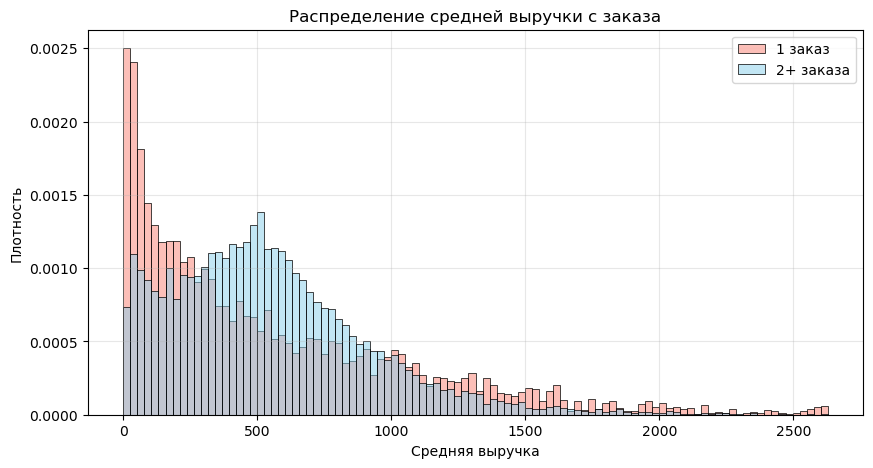

In [76]:
# гистограммы с плотностью по оси y (чтобы сравнивать несмотря на разное количество пользователей)

plt.figure(figsize=(10, 5))

sns.histplot(data=one_time_users, x='avg_revenue', 
             alpha=0.5, label='1 заказ', color='salmon', bins=100, stat='density')
sns.histplot(data=repeat_users, x='avg_revenue', 
             alpha=0.5, label='2+ заказа', color='skyblue', bins=100, stat='density')

plt.title('Распределение средней выручки с заказа')
plt.xlabel('Средняя выручка')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

- Одноразовые пользователи в основном покупают дешёвые билеты (до 300 ₽).
- Вернувшиеся пользователи концентрируются в районе 500 рублей за заказ и преобладают в диапазоне 300 - 1000 рублей.
- Пользователи, сделавшие только один заказ, чаще совершают разовые дорогие покупки, после которых не возвращаются.
- Дорогой средний чек (свыше 1000 рублей) не означает, что пользователь вернётся.

Сравним распределение по средней выручке с заказа ещё в двух группах пользователей.

In [77]:
# разделяем пользователей

# 2 - 4 заказа

two_four_time_users = upfo[upfo['total_orders'].between(2, 4)]

# уже отфильтровано раньше: is five > 4

five_time_users = upfo[upfo['is_five']]  

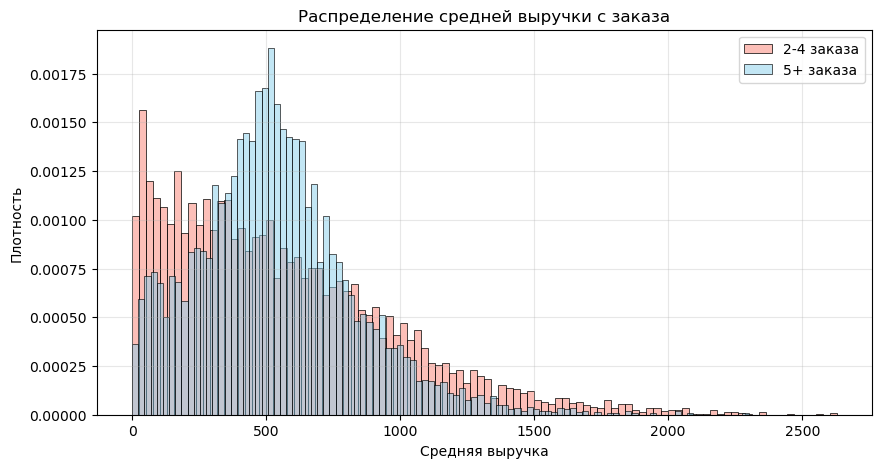

In [78]:
# гистограммы с плотностью по оси y (чтобы сравнивать несмотря на разное количество пользователей)

plt.figure(figsize=(10, 5))

sns.histplot(two_four_time_users, x='avg_revenue', 
             alpha=0.5, label='2-4 заказа', color='salmon', bins=100, stat='density')
sns.histplot(data=five_time_users, x='avg_revenue', 
             alpha=0.5, label='5+ заказа', color='skyblue', bins=100, stat='density')

plt.title('Распределение средней выручки с заказа')
plt.xlabel('Средняя выручка')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Пользователи с 5+ заказами имеют более высокую среднюю выручку с заказа. Их покупки сосредоточены в диапазоне 400–700 рублей.
Пользователи с 2–4 заказами демонстрируют более широкий разброс значений, включая как дешёвые (100 руб), так и дорогие (до 2500 руб) билеты. 
В сегменте более дорогой средней выручки 1000 - 2500 с покупки преобладают пользователи из группы 2-4 заказа.

Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.

In [79]:
# разделяем пользователей на группы

# добавим колонку с сегментом колонку с сегментом

def ticket_segment(x):
    if x <= 2:
        return '1–2 билета'
    elif x <= 3:
        return '2–3 билета'
    elif x <= 5:
        return '3–5 билетов'
    else:
        return '5+ билетов'

# возьмём таблицу всех пользователей

user_profiles_filter = user_profiles_filter.copy()

# применяем

user_profiles_filter['ticket_segment'] = user_profiles_filter['avg_tickets_count'].apply(ticket_segment)

# группируем по получившимся сегментам и считаем метрики

segment_stats = user_profiles_filter.groupby('ticket_segment').agg(
    users_count=('user_id', 'nunique'),
    repeat_users=('total_orders', lambda x: (x > 1).sum()),
    repeat_share=('total_orders', lambda x: (x > 1).mean())
)

# долю в % для наглядности

segment_stats['repeat_share'] = (segment_stats['repeat_share'] * 100).round(2)

segment_stats

,users_count,repeat_users,repeat_share
ticket_segment,,,
1–2 билета,6150,2467,40.11
2–3 билета,10109,7555,74.74
3–5 билетов,5363,3368,62.80
5+ билетов,194,63,32.47


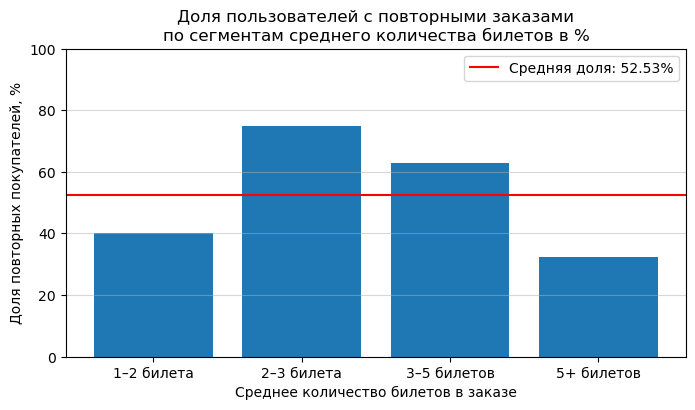

In [80]:
# посмотрим результат на графике

plt.figure(figsize=(8, 4))

avg_share = segment_stats['repeat_share'].mean()

bars = plt.bar(segment_stats.index, segment_stats['repeat_share'])

plt.axhline(avg_share, color='red', label=f"Средняя доля: {avg_share:.2f}%")

plt.title('Доля пользователей с повторными заказами\nпо сегментам среднего количества билетов в %')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Доля повторных покупателей, %')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.5)
plt.legend()
plt.show()

Основная масса пользователей покупает 2–3 билета. Сегмент 5+ билетов — очень маленький и статистически слабый.
Аномально высокая доля повторных покупок: Сегмент 2–3 билета — 74.74%. Можно считать это аномально высоким относительно других групп.

### Исследование временных характеристик первого заказа и их влияния на повторные покупки
Изучим временные параметры, связанные с первым заказом пользователей.

Проанализируем, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

In [81]:
# добавляем день недели первой покупки в таблицу

# берём день недели из first_order_date

user_profiles_filter['first_order_weekday'] = pd.to_datetime(user_profiles_filter['first_order_date']).dt.day_name()

# группируем по дням и считаем пользователей

user_first_order_weekday = user_profiles_filter.groupby('first_order_weekday', observed=True)['user_id'].count().sort_values(ascending=False)

# переименуем чтобы понятно всем было

weekday_ru = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}

# переименовываем индексы

user_first_order_weekday_ru = user_first_order_weekday.rename(index=weekday_ru)

ufow_ru = user_first_order_weekday_ru

ufow_ru

first_order_weekday
Суббота        3434
Пятница        3258
Вторник        3188
Четверг        3119
Среда          3076
Понедельник    2931
Воскресенье    2810
Name: user_id, dtype: int64

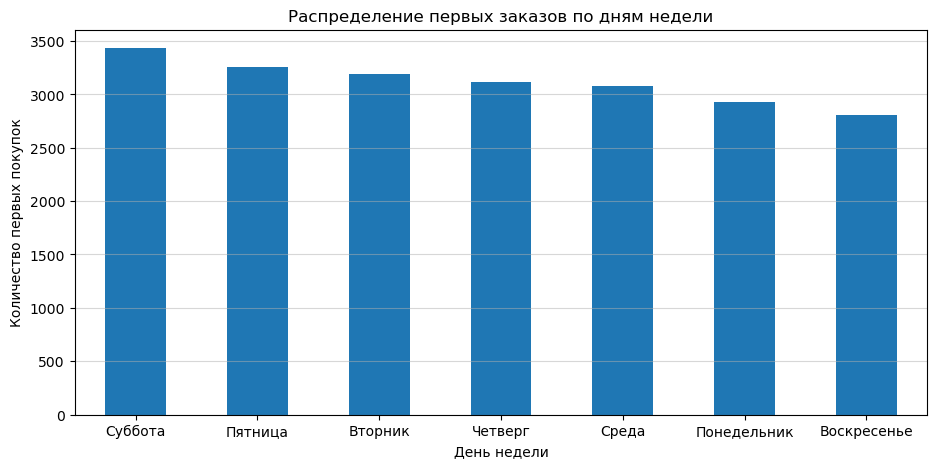

In [82]:
# посмотрим что получилось

plt.figure(figsize=(11, 5))
ufow_ru.plot(kind='bar')

plt.title('Распределение первых заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество первых покупок')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

In [83]:
# смотрим лайфтайм

# берём пользователей больше одного заказа и считаем разницу - отфильтрованно раньше

upfo['lifetime_days'] = (upfo['last_order_date'] - upfo['first_order_date']).dt.days

upfo['lifetime_days'].describe()

count    13453.000000
mean        63.690478
std         53.880180
min          0.000000
25%          5.000000
50%         58.000000
75%        116.000000
max        152.000000
Name: lifetime_days, dtype: float64

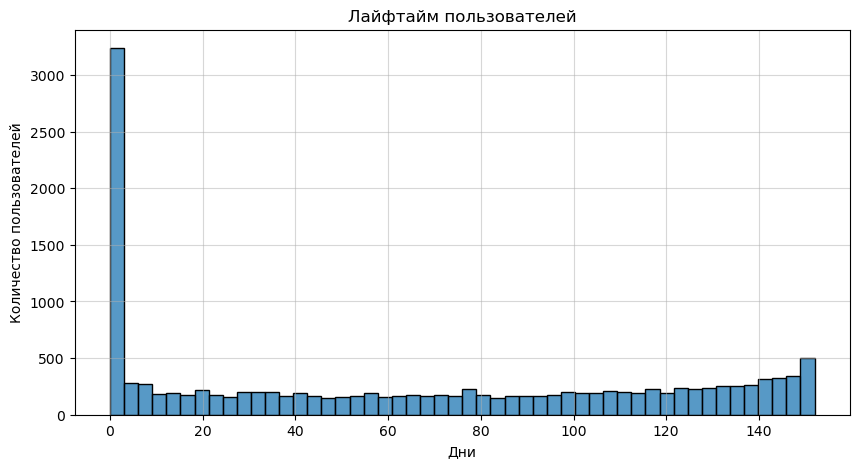

In [84]:
plt.figure(figsize=(10, 5))

sns.histplot(upfo['lifetime_days'], bins=50)

plt.title('Лайфтайм пользователей')
plt.xlabel('Дни')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.5)
plt.show()

Сильное смещение в сторону нуля, много нулевых значений, где пользователи совершали повторные заказы в один день.

In [85]:
# отфильтруем пользователей по лайфтайм больше нуля

user_profiles_filter_lifetime = upfo[upfo['lifetime_days'] > 0]

upfl = user_profiles_filter_lifetime

upfl = upfl.reset_index(drop=True)

upfl['lifetime_days'].describe()

count    10735.000000
mean        79.816302
std         48.486591
min          1.000000
25%         35.000000
50%         83.000000
75%        125.000000
max        152.000000
Name: lifetime_days, dtype: float64

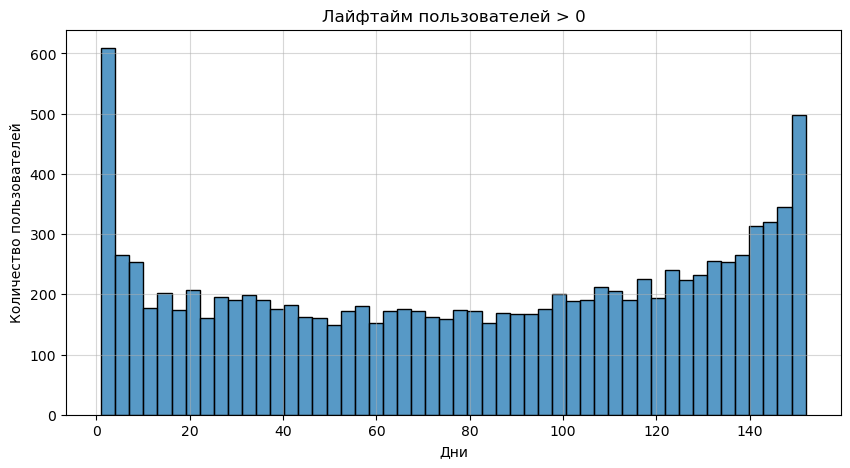

In [86]:
# смотрим как распределяется лайфтайм без нулевых значений

plt.figure(figsize=(10, 5))

sns.histplot(upfl['lifetime_days'], bins=50)

plt.title('Лайфтайм пользователей > 0')
plt.xlabel('Дни')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.5)
plt.show()

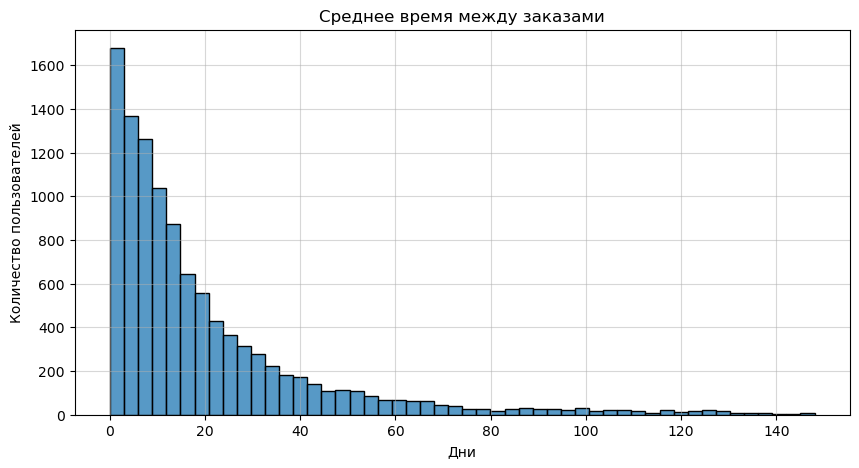

In [87]:
# смотрим как распределяется среднее время между заказами

# сразу отфильтруем таблицу по среднему интервалу больше нуля

upfd = upfo[upfo['avg_days_between_orders'] > 0 ]

plt.figure(figsize=(10, 5))

sns.histplot(upfd['avg_days_between_orders'], bins=50)

plt.title('Среднее время между заказами')
plt.xlabel('Дни')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.5)
plt.show()

Проанализируем, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

In [88]:
# берём только повторных, берём день недели, переводим на ру, считаем

# смотрим сколько повторных заказов было в этот день

repeat_weekday = upfo['first_order_date'].dt.day_name()

# переводим на русский

repeat_weekday_ru = repeat_weekday.map(weekday_ru)

# считаем количество

repeat_weekday_ru = repeat_weekday_ru.value_counts()

# всего посчитанные по дням недели есть, собираем в одну таблицу
                        
repeat_weekday_share= pd.DataFrame({'Всего первых покупок': ufow_ru, 'Повторные покупки': repeat_weekday_ru})

# считаем долю в %

repeat_weekday_share['Доля повторных, %'] = (repeat_weekday_share['Повторные покупки'] / repeat_weekday_share['Всего первых покупок'] * 100).round(2)

repeat_weekday_share.sort_values('Доля повторных, %', ascending=False)

,Всего первых покупок,Повторные покупки,"Доля повторных, %"
Суббота,3434,2197,63.98
Понедельник,2931,1851,63.15
Среда,3076,1921,62.45
Вторник,3188,1978,62.05
Воскресенье,2810,1701,60.53
Пятница,3258,1948,59.79
Четверг,3119,1857,59.54


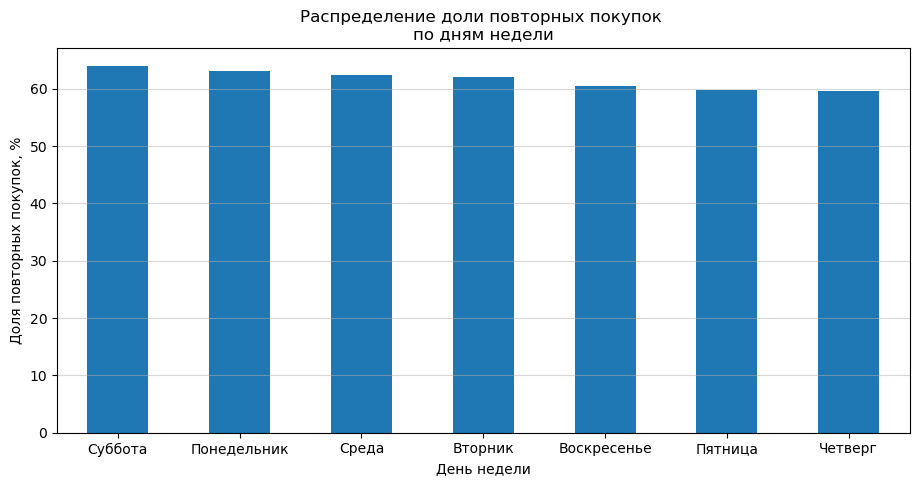

In [89]:
# смотрим в какой день больше всего повторных

repeat_weekday_share_sorted = repeat_weekday_share.sort_values('Доля повторных, %', ascending=False)

plt.figure(figsize=(11, 5))
repeat_weekday_share_sorted['Доля повторных, %'].plot(kind='bar')

plt.title('Распределение доли повторных покупок \nпо дням недели')
plt.xlabel('День недели')
plt.ylabel('Доля повторных покупок, %')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

Доля повторных заказов слабо зависит от дня недели первой покупки:
- суббота — лидер по доле повторных (52.18%) при максимальном количестве пользователей (тут всё логически верно - 1ый выходной)
- воскресенье – среда — стабильно высокие возвраты (49 - 50%)
- четверг – пятница — самые низкие показатели.

Я бы сказал, что прям ярко выраженного лидера тут нет. Да, суббота, но в субботу практически везде показатели выше. Будь то автосервис или ресторан. Ничего необычного. В понедельник - вторник скорее всего люди заранее покупают билеты на мероприятия, бронируют, оплачивают, чтобы не суетиться.

Посмотрим, как средний интервал между заказами влияет на удержание клиентов.

In [90]:
# среднее время между заказами для каждой группы

# соберём в одну таблицу группы пользователей, которые определили раньше

avg_time_group = pd.DataFrame({
    'Группа': ['2–4 заказа', '5+ заказов'],
    'Пользователей': [len(two_four_time_users), len(five_time_users)],
    'Среднее время между заказами, дней': [
        two_four_time_users['avg_days_between_orders'].mean().round(2),
        five_time_users['avg_days_between_orders'].mean().round(2)
    ]
}).set_index('Группа')

avg_time_group 

,Пользователей,"Среднее время между заказами, дней"
Группа,,
2–4 заказа,7143,21.35
5+ заказов,6310,9.62


Пользователи, которые в среднем делают заказ раз в 9–10 дней, в итоге совершают 5 и более покупок (6310 человек).
Те, кто делает заказы раз в 3 недели и реже, редко переходят в категорию 5 + заказов — у них в 2.2 раза больший средний интервал.

## Корреляционный анализ количества покупок и признаков пользователя
Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок.

In [91]:
# выделим нужные столбцы под корреляцию

phik_users = user_profiles_filter[[
    'total_orders',
    'avg_days_between_orders',
    'avg_revenue',
    'avg_tickets_count',
    'first_device',
    'first_region',
    'first_service',
    'first_event_type'
]]

# укажем интервальные колонки

phik_users_matrix = phik_users.phik_matrix(interval_cols = ['total_orders', 'avg_revenue', 'avg_tickets_count', 'avg_days_between_orders'])

display(phik_users_matrix)

,total_orders,avg_days_between_orders,avg_revenue,avg_tickets_count,first_device,first_region,first_service,first_event_type
total_orders,1.000000,0.046656,0.087720,0.087246,0.018856,0.000000,0.078641,0.012359
avg_days_between_orders,0.046656,1.000000,0.086957,0.102380,0.017144,0.073600,0.054814,0.048510
avg_revenue,0.087720,0.086957,1.000000,0.459075,0.073990,0.357565,0.379841,0.325935
avg_tickets_count,0.087246,0.102380,0.459075,1.000000,0.054975,0.163608,0.067595,0.095088
first_device,0.018856,0.017144,0.073990,0.054975,1.000000,0.115160,0.082388,0.060899
first_region,0.000000,0.073600,0.357565,0.163608,0.115160,1.000000,0.696732,0.509887
first_service,0.078641,0.054814,0.379841,0.067595,0.082388,0.696732,1.000000,0.589085
first_event_type,0.012359,0.048510,0.325935,0.095088,0.060899,0.509887,0.589085,1.000000


In [92]:
# Создаём три датасета по сегментам

seg_1 = phik_users[phik_users['total_orders'] < 2]
seg_2_4 = phik_users[phik_users['total_orders'].between(2, 4)]
seg_5_plus = phik_users[phik_users['total_orders'] > 5]

# Считаем phik для каждого сегмента

phik_1 = seg_1.phik_matrix(interval_cols = ['total_orders', 'avg_revenue', 'avg_tickets_count', 'avg_days_between_orders'])
phik_2_4 = seg_2_4.phik_matrix(interval_cols = ['total_orders', 'avg_revenue', 'avg_tickets_count', 'avg_days_between_orders'])
phik_5_plus = seg_5_plus.phik_matrix(interval_cols = ['total_orders', 'avg_revenue', 'avg_tickets_count', 'avg_days_between_orders'])

D:\Anaconda3.com\Anaconda3\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable total_orders for analysis 1. Dropping this column
  warnings.warn(


In [93]:
# составим функцию с проверкой возможности подсчёта показателей.
# если основная колонка total_orders не подходит для анализа в какой-либо группе - выведем сообщение

def print_phik(phik_matrix, segment_name):
    print(segment_name)
    print()
    
    # проверяем, есть ли колонка total_orders в матрице корреляции
    
    if 'total_orders' not in phik_matrix.columns:
        print(f"Невозможно рассчитать корреляцию: все значения total_orders = константа\n")
        return
    else:
        print(phik_matrix['total_orders'].sort_values(ascending=False).round(3))
        print()


print_phik(phik_1, "1 заказ")
print_phik(phik_2_4, "2–4 заказа")
print_phik(phik_5_plus, "5+ заказов")

1 заказ

Невозможно рассчитать корреляцию: все значения total_orders = константа

2–4 заказа

total_orders               1.000
avg_days_between_orders    0.386
avg_tickets_count          0.369
avg_revenue                0.109
first_service              0.070
first_device               0.010
first_region               0.000
first_event_type           0.000
Name: total_orders, dtype: float64

5+ заказов

total_orders               1.000
avg_days_between_orders    0.349
avg_revenue                0.156
first_service              0.116
avg_tickets_count          0.104
first_device               0.032
first_event_type           0.030
first_region               0.000
Name: total_orders, dtype: float64



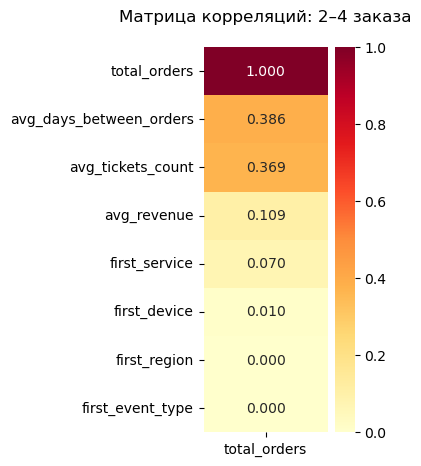

In [94]:
plt.figure(figsize=(2, 5))
sns.heatmap(phik_2_4[['total_orders']].sort_values(by='total_orders', ascending=False), annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Матрица корреляций: 2–4 заказа\n")
plt.show()

Наиболее связанные признаки:

`avg_days_between_orders (0.386)`
Чем меньше интервал между покупками, тем выше шанс дойти до верхнего предела сегмента (4 заказа).

`avg_tickets_count (0.369)`
Пользователи, покупающие больше билетов за раз, чаще совершают больше покупок.

`avg_revenue (0.109)` — связь слабая, но присутствует.

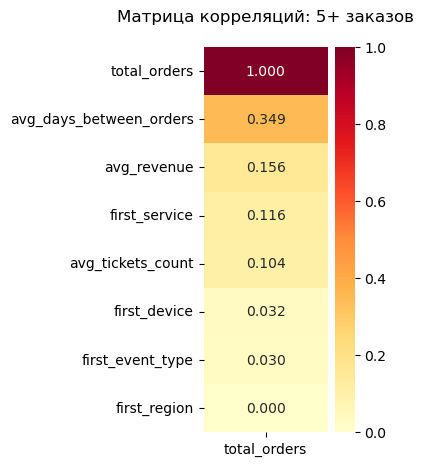

In [95]:
plt.figure(figsize=(2, 5))
sns.heatmap(phik_5_plus[['total_orders']].sort_values(by='total_orders', ascending=False), annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Матрица корреляций: 5+ заказов\n")
plt.show()

Наиболее связанные признаки:

`avg_days_between_orders (0.291)`
Чем меньше средний интервал между покупками, тем больше заказов у пользователя.
Это логично: активные пользователи покупают часто.

`avg_revenue (0.153)`
Пользователи с большим средним чеком чаще становятся постоянными клиентами.

`first_service (0.119)`
Cервис первой покупки слабо, но влияет на вовлечённость (некоторые площадки лучше мотивируют к повторным покупкам).

`avg_tickets_count потерял влияние (0.047)` — для 5+ пользователей количество билетов в одном заказе не так важно.

Общий итог: какие признаки сильнее всего связаны с total_orders?

1. Средний интервал между заказами (avg_days_between_orders)
Самая стабильная сильная связь во всех сегментах.

2. Среднее количество билетов (avg_tickets_count)
Сильно влияет в сегменте 2–4 заказов, меньше в 5+.

3. Средний чек (avg_revenue)
Умеренная связь, усиливается в сегменте 5+.

4. Тип первой услуги (first_service)
Влияет только у пользователей 5+ заказов.

## Общие выводы и рекомендации

Исходные данные:

- Данные выгружены из PostgreSQL базы данных Яндекс Афиши через SQL-запрос с объединением таблиц покупок (purchases), мероприятий (events), городов (city) и регионов (regions)
- На этапе выгрузки уже применена фильтрация: только устройства mobile и desktop, исключены фильмы (event_type_main != 'фильм')
- Исходный датасет содержал 290 611 записей о заказах.

Подготовка данных:

Конвертация валют:

- выручка хранилась в двух валютах: RUB и KZT
- для тенге выполнена конвертация в рубли по актуальному курсу на дату каждого заказа
- результат сохранён в новый столбец revenue_rub


Обработка пропусков:

- пропуски обнаружены только в столбце days_since_prev (7.5%) — это ожидаемо, так как для первых заказов пользователей предыдущего заказа нет


Обработка дубликатов:

- полных дубликатов не найдено
- обнаружено 4 группы логических дубликатов: один пользователь, одна секунда, одно мероприятие, но разные устройства (desktop и mobile) — такие заказы физически невозможны
- решение: удалены desktop заказы, оставлены mobile


Фильтрация выбросов по выручке:

- минимальное значение было −90.76 руб (ошибка), максимум — 81 174 руб (экстремальный выброс)
- применена фильтрация по 99-му перцентилю (2628) + удалены отрицательные значения
- удалено 3206 строк
- нулевая выручка оставлена (подарочные заказы, бонусы, призы)


Оптимизация типов данных:

- категориальные столбцы (device, currency, event_type, service_name) преобразованы в тип category
- числовые столбцы оптимизированы: float64 - float32, int64 - int32/int8
- размер датафрейма сокращён с 45 MB до 21 MB

Итоговый датасет после очистки: 287 401 запись

Основные результаты анализа:

Общая статистика по пользователям:

- в выборке 21 816 уникальных пользователей (после очистки выбросов)
- период данных: июнь — октябрь 2024 (5 месяцев)
- средняя выручка с заказа: 519 рублей
- 62% пользователей совершили 2+ заказа
- 29% пользователей совершили 5+ заказов

Признаки первого заказа, связанные с возвратом:

- mobile и desktop показывают практически одинаковую конверсию в повторные покупки
- концерты (62%) лучше удерживают, чем спорт (56%). Гипотеза о преимуществе спорта не подтвердилась
- лидеры по возврату: Край билетов, Дом культуры, Весь в билетах, Билеты в рукиб рачечная — выше средней по всем сервисам
- Шанырский регион (67.5%) и Светополянский округ (66%) — лучшие по удержанию

Выручка и количество билетов:

- пользователи с 5+ заказами имеют средний чек в диапазоне 400–700 рублей
- пользователи с 2–4 заказами покупают как дешёвые (100 руб), так и дорогие (до 2500 руб)
Временные характеристики:
- день недели первой покупки слабо влияет на возврат (разброс 59.5% – 64%), но суббота и понедельник немного лучше
- средний интервал между заказами — ключевой показатель: чем меньше дней между покупками, тем выше вероятность стать постоянным клиентом
- основная масса повторных покупателей делает следующий заказ в течение 1–7 дней

Корреляционный анализ:

Средний интервал между заказами (avg_days_between_orders) - Самая стабильная сильная связь во всех сегментах.

Интересные наблюдения:

Тип устройства и регион не коррелируют с количеством заказов
Сервис и регион сильно связаны между собой (0.70) — вероятно, некоторые сервисы доминируют в определённых регионах


Рекомендации:

1. Фокус на сегменте `2–3 билета в заказе`


Это самый перспективный сегмент с конверсией в повторные покупки 74.7%. Рекомендую стимулировать покупку именно 2–3 билетов: предлагать скидки на второй билет, формировать предложения билет + друг.

3. Работа с интервалом между заказами

Средний интервал между покупками — ключевой фактор лояльности. Для удержания важно вернуть пользователя в течение первых 7 дней после покупки. Рекомендую настроить триггерные рассылки с персональными рекомендациями на 3-й и 7-й день после заказа, использовать push-уведомления о событиях в том же жанре/месте.

3. Внимание к проблемным регионам

Озернинский край и Малиновоярский округ показывают возврат ниже среднего. Рекомендую провести отдельное исследование: возможно, проблема в ассортименте событий, логистике или конкурентах в этих регионах.